# Análise de Inibição do CYP2C9 

**Docente:** Miguel Rocha

**Trabalho realizado por:**
- Bárbara Freitas PG55693
- Filipe Vasconcelos PG55697
- João Faria PG55700 
- Vítor Silva PG55538  

**Data:** 13/06/2025  
**Extração de Conhecimento de Dados Biológicos**

---

Este notebook apresenta uma análise abrangente de um conjunto de dados biológicos, com foco na previsão da inibição da enzima CYP2C9 por compostos químicos, utilizando técnicas modernas de ciência de dados e machine learning em Python. O trabalho segue as etapas recomendadas para extração de conhecimento de dados biológicos, desde a exploração inicial até a interpretação dos resultados dos modelos de previsão.

## Contextualização

O CYP2C9 é uma enzima do citocromo P450 envolvida no metabolismo de diversos fármacos. A identificação de compostos capazes de inibir esta enzima é fundamental para o desenvolvimento seguro de novos medicamentos, pois a inibição pode levar a interações indesejadas. Este estudo utiliza um dataset de compostos químicos, cada um descrito por um conjunto de variáveis numéricas (descritores moleculares), para construir modelos capazes de prever a inibição do CYP2C9.

**Referência dos dados:**  
Veith, Henrike et al. “Comprehensive characterization of cytochrome P450 isozyme selectivity across chemical libraries.” *Nature Biotechnology*, vol. 27, 11 (2009): 1050-5.

---

## Objetivos do Trabalho

- **Analisar e descrever o conjunto de dados:** Exploração inicial, identificação de características relevantes.
- **Pré-processamento:** Aplicação de técnicas de limpeza, normalização e seleção de variáveis.
- **Sumarização estatística e visualização:** Estatísticas descritivas e gráficos para melhor compreender os dados.
- **Análise multivariada não supervisionada:** Aplicação de métodos como clustering e redução de dimensionalidade (PCA, t-SNE) para explorar padrões e estruturas nos dados.
- **Modelação preditiva:** Construção e comparação de diferentes modelos de classificação, incluindo otimização de hiperparâmetros e avaliação com métricas apropriadas.
- **Seleção e importância de variáveis:** Identificação dos descritores moleculares mais relevantes para a previsão.
- **Interpretação dos modelos:** Utilização de ferramentas como SHAP e LIME para explicar as decisões dos modelos.
- **Discussão dos resultados:** Reflexão crítica sobre a pipeline, os resultados obtidos e possíveis melhorias.

---

## Descrição do Conjunto de Dados

O dataset analisado contém **11.934 compostos químicos**, cada um representado por **208 descritores moleculares** (variáveis numéricas) que capturam diferentes propriedades físico-químicas e estruturais das moléculas. O alvo (`Y`) é uma variável binária que indica se o composto é ou não um inibidor do CYP2C9. Os dados estão organizados em dois ficheiros CSV: um com as features e outro com os rótulos.

O objetivo central deste trabalho é desenvolver um pipeline robusto para prever a inibição do CYP2C9 a partir dos descritores moleculares para perceber os fatores que influenciam a atividade enzimática.

---

# Importação das Bibliotecas e Packages

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import lime
import lime.lime_tabular

from sklearn.model_selection import (
    train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
)
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score, roc_curve, accuracy_score, adjusted_rand_score
)
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.feature_selection import RFECV
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from imblearn.over_sampling import SMOTE

# Carregamento e Visualização Inicial dos Dados

In [5]:
features_path = r"C:\Users\jf823\Desktop\python\trab_extracao\cyp2c9\cyp2c9_features.csv"
outputs_path  = r"C:\Users\jf823\Desktop\python\trab_extracao\cyp2c9\cyp2c9_outputs.csv"

X = pd.read_csv(features_path)
y = pd.read_csv(outputs_path)['Y']

print("Features shape:", X.shape)
print("Labels shape:", y.shape)
X.head()

Features shape: (11934, 208)
Labels shape: (11934,)


,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,NumRadicalElectrons,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,12.820479,-0.183140,12.820479,0.128619,0.457873,362.476,344.332,362.07590,126.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,6.126257,0.660427,6.126257,0.660427,0.756902,255.708,245.628,255.05632,88.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,5.719940,-0.219974,5.719940,0.075509,0.605920,421.549,390.301,421.25900,164.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,12.040634,-0.208718,12.040634,0.006714,0.728361,324.344,308.216,324.13348,122.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,13.082813,-0.044883,13.082813,0.018472,0.457249,495.628,458.332,495.29578,194.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


O carregamento e a visualização inicial dos dados são etapas fundamentais em qualquer pipeline de ciência de dados, a qualidade e a estrutura dos dados impactam diretamente a robustez das análises subsequentes. Nesta fase, foram utilizados comandos para importar os datasets de features e rótulos, seguidos de uma inspeção das suas dimensões e visualização das primeiras linhas.

Primeiro, os ficheiros CSV contendo os descritores moleculares dos compostos químicos (cyp2c9_features.csv) e os rótulos (cyp2c9_outputs.csv) foram lidos utilizando a biblioteca pandas. O comando X = pd.read_csv(features_path) carrega as 208 variáveis numéricas (descritores moleculares) para cada um dos 11.934 compostos, enquanto y = pd.read_csv(outputs_path)['Y'] extrai a coluna alvo binária, que indica se cada composto é ou não um inibidor do CYP2C9.

A seguir, os comandos print("Features shape:", X.shape) e print("Labels shape:", y.shape) permitem confirmar que o número de amostras e de variáveis está conforme o esperado: 11.934 linhas (compostos) e 208 colunas (descritores) para as features, e 11.934 rótulos. Esta verificação é essencial para garantir que não há discrepâncias entre os datasets, como linhas em falta ou desalinhamento entre as tabelas de entrada e saída, o que poderia comprometer toda a análise.

A visualização das primeiras linhas do dataframe de features, através do comando X.head(), permite uma visualização rápida dos dados, confirmando que os valores são numéricos e que não existem aparentes anomalias ou erros de leitura. Esta etapa é importante para identificar possíveis problemas de formatação, valores ausentes ou inconsistências que possam ter ocorrido durante a exportação ou manipulação dos dados.

A realização destes passos justifica-se pela necessidade de garantir a integridade e a qualidade dos dados antes de avançar para etapas mais complexas, como a análise exploratória, pré-processamento e modelagem preditiva. A confirmação das dimensões e do tipo dos dados assegura que o pipeline pode prosseguir de forma segura, minimizando o risco de erros nas fases seguintes.

# Carregamento e Visualização Inicial dos Outputs

In [31]:
y = pd.read_csv(outputs_path)
print("Outputs shape:", y.shape)
y.head()

Outputs shape: (11934, 3)


,ids,smiles,Y
0,1960010.0,CCN1C(=O)/C(=C2\SC(=S)N(CCCOC)C2=O)c2ccccc21,1
1,644851.0,Clc1ccccc1-c1nc(-c2ccccc2)n[nH]1,1
2,644890.0,COc1ccccc1C(c1nnnn1C(C)(C)C)N1CCN(Cc2ccncc2)CC1,1
3,644968.0,COc1ccccc1CNC(=O)Cn1nnc(-c2ccncc2)n1,1
4,645164.0,CCC(c1nnnn1CC1CCCO1)N(CCN1CCOCC1)Cc1cc2cc(C)cc...,0


A etapa de carregamento e visualização inicial dos outputs é fundamental para garantir a integridade e a correta compreensão dos dados que servirão como alvo (rótulo) na modelação preditiva. O comando y = pd.read_csv(outputs_path) lê o ficheiro CSV contendo os outputs, que neste caso apresenta três colunas: ids, smiles e Y, e 11.934 linhas, conforme indicado pelo output Outputs shape: (11934, 3). O comando y.head() exibe as primeiras linhas do dataframe.

A coluna ids corresponde a identificadores únicos dos compostos químicos, enquanto a coluna smiles contém a representação estrutural das moléculas em formato SMILES, útil para rastreabilidade e possíveis análises químicas adicionais. A coluna Y é o alvo binário (0 ou 1), indicando se o composto é ou não um inibidor do CYP2C9, sendo esta a variável de interesse para os modelos de classificação.

A realização destes comandos tem como objetivo principal validar a estrutura do ficheiro de outputs, assegurando que o número de linhas corresponde ao das features e que as colunas necessárias estão presentes e corretamente formatadas. A verificação visual das primeiras linhas permite identificar rapidamente possíveis problemas, como valores ausentes, erros de formatação ou inconsistências nos dados.

Além disso, esta etapa é crucial para garantir que apenas a coluna Y será utilizada como rótulo nos modelos preditivos, evitando o uso inadvertido de informações que poderiam enviesar os resultados (como os identificadores ou as estruturas químicas). O correto isolamento da coluna Y é posteriormente realizado no pipeline, assegurando que a previsão se baseia exclusivamente na relação entre os descritores moleculares (features) e o alvo de interesse.

# Extração da coluna de rótulos

In [32]:
y = pd.read_csv(outputs_path)
if isinstance(y, pd.DataFrame):
    y = y['Y']

# Análise exploratória 

In [35]:
print("Tipos de dados:\n", X.dtypes.value_counts())
print("\nValores ausentes nas features:", X.isnull().sum().sum())
print("Valores ausentes nos rótulos:", y.isnull().sum())

display(X.describe())

Tipos de dados:
 float64    208
Name: count, dtype: int64

Valores ausentes nas features: 0
Valores ausentes nos rótulos: 0


,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,NumRadicalElectrons,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
count,11934.000000,11934.000000,11934.000000,11934.000000,11934.000000,11934.000000,11934.000000,11934.000000,11934.000000,11934.0,...,11934.000000,11934.000000,11934.000000,11934.000000,11934.000000,11934.000000,11934.000000,11934.000000,11934.000000,11934.000000
mean,11.274808,-0.879382,11.274808,0.192623,0.611521,355.016700,334.581007,354.626917,131.051114,0.0,...,0.101894,0.073571,0.011061,0.004190,0.009804,0.032261,0.000168,0.062929,0.127786,0.044076
std,2.689638,1.442954,2.689638,0.224866,0.191307,108.988404,103.017461,108.873587,40.828041,0.0,...,0.325473,0.271160,0.104592,0.064595,0.101878,0.189071,0.012945,0.250991,0.774506,0.213281
min,2.269884,-7.603764,2.269884,0.000000,0.021258,33.030000,30.006000,33.021465,14.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,10.896393,-1.063285,10.896393,0.043124,0.481696,289.292000,272.175000,289.024430,106.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,12.242406,-0.402087,12.242406,0.116725,0.632182,347.435000,327.159000,347.133635,128.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,12.924319,-0.062750,12.924319,0.237865,0.772312,409.507250,386.231750,409.140095,152.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,17.398045,3.500000,17.398045,3.811700,0.947210,1664.922000,1579.242000,1663.492300,606.000000,0.0,...,4.000000,3.000000,1.000000,1.000000,2.000000,4.000000,1.000000,2.000000,26.000000,4.000000


A análise exploratória e sumarização dos dados é uma etapa fundamental pois permite avaliar a qualidade, a estrutura e as características do conjunto de dados.

O comando print("Tipos de dados:\n", X.dtypes.value_counts()) verifica os tipos de dados presentes nas features. O resultado indica que todas as 208 variáveis são do tipo float64, o que é ideal para análises quantitativas e para a aplicação de algoritmos de machine learning, que geralmente requerem dados numéricos contínuos. A homogeneidade dos tipos de dados simplifica o pré-processamento e evita a necessidade de conversões ou tratamentos adicionais.

Em seguida, os comandos print("\nValores ausentes nas features:", X.isnull().sum().sum()) e print("Valores ausentes nos rótulos:", y.isnull().sum()) avaliam a presença de valores ausentes tanto nas features quanto nos rótulos. O resultado mostra que não há valores ausentes em nenhuma das variáveis nem nos rótulos. Isso é extremamente positivo, pois elimina a necessidade de técnicas de imputação ou exclusão de amostras, que poderiam introduzir viés ou reduzir o poder estatístico da análise.

O comando display(X.describe()) gera estatísticas descritivas para todas as features, incluindo medidas como média, desvio padrão, valores mínimos e máximos, e os quartis (25%, 50% e 75%). Essas estatísticas permitem identificar a distribuição e a variabilidade das variáveis, além de possíveis outliers ou discrepâncias. Por exemplo, a análise dos valores mínimos e máximos pode revelar a presença de valores extremos, enquanto a comparação entre os quartis e a média pode indicar assimetrias nas distribuições. A diversidade de amplitudes e desvios padrão entre as features reforça a necessidade de padronização dos dados, para evitar que variáveis com escalas maiores dominem o processo de aprendizagem dos modelos.

Há necessidade de garantir a integridade, consistência e adequação dos dados para as etapas seguintes do pipeline. A ausência de valores ausentes e a homogeneidade dos tipos de dados são indicativos de um conjunto de dados bem preparado, enquanto as estatísticas descritivas orientaram decisões sobre pré-processamento, seleção de variáveis e escolha de algoritmos.

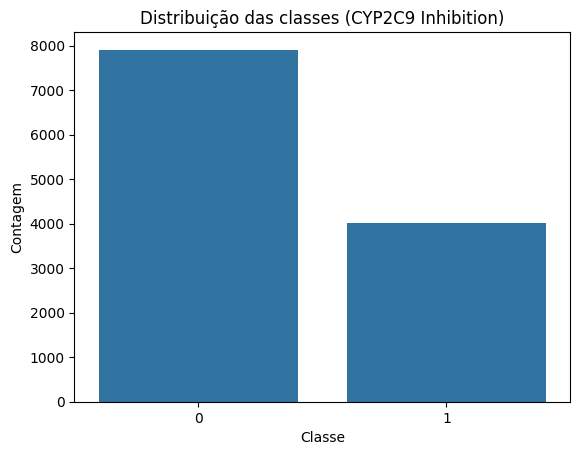

In [34]:
if isinstance(y, pd.DataFrame):
    y_plot = y['Y']
else:
    y_plot = y
sns.countplot(x=y_plot)
plt.title("Distribuição das classes (CYP2C9 Inhibition)")
plt.xlabel("Classe")
plt.ylabel("Contagem")
plt.show()

A análise da distribuição das classes, representada pelo gráfico de barras gerado, é uma etapa essencial especialmente em problemas de classificação binária como a previsão de inibição do CYP2C9. O objetivo deste passo é avaliar o equilíbrio entre as classes do alvo (Y), que neste caso indica se um composto é ou não inibidor da enzima.

O gráfico apresentado mostra claramente um desbalanceamento entre as classes: a classe 0 (não inibidores) possui aproximadamente o dobro de amostras em relação à classe 1 (inibidores). A identificação deste desbalanceamento é fundamental, pois modelos de machine learning tendem a favorecer a classe mais presente em situações de desbalanceamento.


A constatação do desbalanceamento justifica a necessidade de técnicas específicas, como o uso de métodos de oversampling ou ajuste de pesos das classes nos algoritmos, para garantir que o modelo aprenda a reconhecer adequadamente ambas as classes.


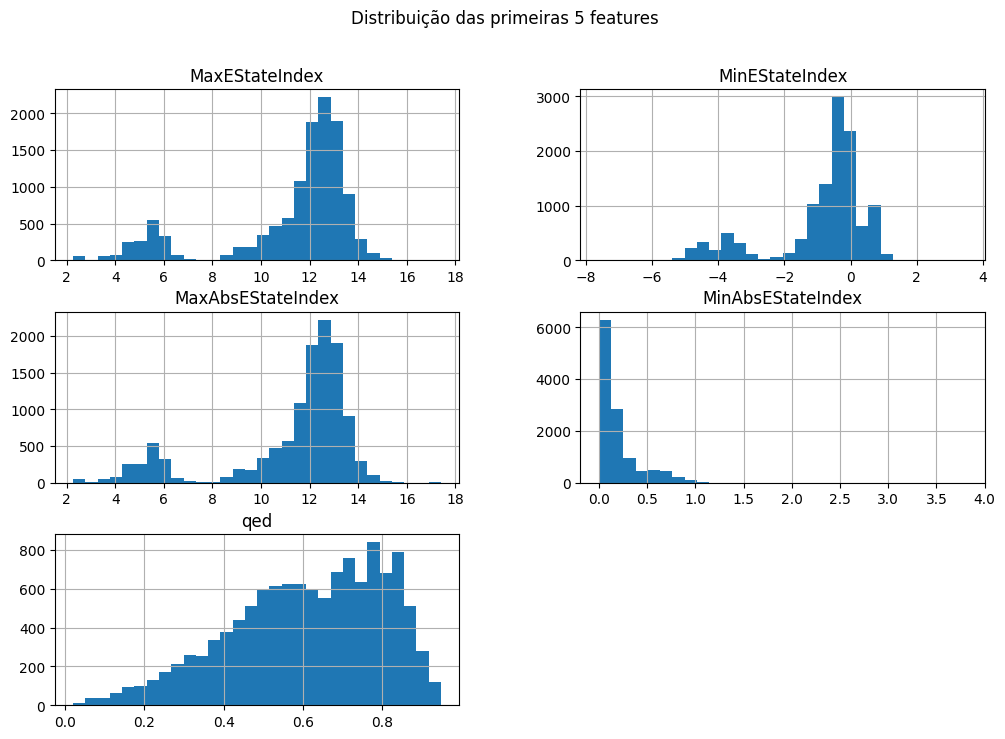

In [33]:
X.iloc[:, :5].hist(bins=30, figsize=(12,8))
plt.suptitle("Distribuição das primeiras 5 features")
plt.show()

O objetivo principal deste passo é compreender a distribuição individual das variáveis (descritores moleculares), identificar padrões, assimetrias, possíveis outliers e avaliar a necessidade de transformações ou pré-processamentos adicionais antes da modelagem preditiva.

A escolha de visualizar as primeiras cinco features permite uma amostra representativa do comportamento geral dos descritores. Observando os histogramas:

MaxEStateIndex e MaxAbsEStateIndex: Apresentam distribuições aproximadamente normais, mas com caudas à esquerda, sugerindo a presença de alguns valores mais baixos que podem ser considerados outliers. A concentração dos dados em torno de um valor central indica baixa variabilidade para a maioria dos compostos, mas a existência de caudas pode impactar algoritmos sensíveis a outliers.
MinEStateIndex: Exibe uma distribuição assimétrica, com uma cauda longa à esquerda (valores negativos), indicando que alguns compostos possuem valores extremos para este descritor. Essa assimetria pode afetar a performance de modelos lineares e reforça a importância de padronização.
MinAbsEStateIndex: Mostra uma distribuição fortemente assimétrica à direita, com a maioria dos valores próximos de zero e poucos valores mais altos. Essa característica é comum em variáveis que representam medidas absolutas ou distâncias, e pode indicar que a maioria dos compostos tem baixa variação neste descritor.
qed: Apresenta uma distribuição aproximadamente uniforme entre 0,2 e 0,9, com leve concentração em valores mais altos. O parâmetro QED (Quantitative Estimate of Drug-likeness) é importante em química medicinal, e sua distribuição sugere que o dataset contém compostos com diferentes graus de "drug-likeness".
A razão para a execução deste comando é múltipla:

Diagnóstico de assimetrias e outliers:
A visualização permite identificar rapidamente variáveis com distribuições não normais, caudas longas ou valores extremos, que podem influenciar negativamente a performance de certos algoritmos de machine learning. Isso orienta a escolha de técnicas de pré-processamento, como padronização, normalização ou até mesmo transformação logarítmica.

Avaliação da necessidade de padronização:
Como as features apresentam escalas e distribuições distintas, a padronização torna-se essencial para garantir que todas as variáveis contribuam de forma equilibrada para o processo de aprendizagem dos modelos, evitando que descritores com maior amplitude dominem a modelagem.

Compreensão da variabilidade dos dados:
Features com baixa variabilidade podem ser pouco informativas para a classificação e, portanto, candidatas à remoção em etapas de seleção de variáveis. 

Transparência e rastreabilidade:
Documentar e visualizar a distribuição das features é uma boa prática, pois permite que outros pesquisadores compreendam as características do dataset e as decisões tomadas no pipeline.

# Pré-processamento dos dados

In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

assert not np.isnan(X_scaled).any(), "Existem valores NaN nas features!"

O comando scaler = StandardScaler() inicializa o objeto responsável por transformar cada feature para que tenha média zero e desvio padrão igual a um. Em seguida, X_scaled = scaler.fit_transform(X) aplica essa transformação a todo o conjunto de dados de entrada.

A principal razão para realizar a padronização é garantir que todas as variáveis contribuam de forma equilibrada para o processo de aprendizagem dos modelos de machine learning. Muitos algoritmos, como SVM, K-means, PCA e até mesmo redes neurais, são sensíveis à escala das variáveis. Se as features estiverem em escalas muito diferentes, aquelas com valores absolutos maiores podem dominar o processo de otimização, prejudicando a capacidade do modelo de aprender padrões relevantes em variáveis de menor amplitude. 

Após a padronização, o comando assert not np.isnan(X_scaled).any(), "Existem valores NaN nas features!" é utilizado como uma verificação de integridade. Ele garante que o processo de transformação não introduziu valores ausentes (NaN) nas features, o que poderia comprometer todas as etapas subsequentes do pipeline. A ausência de NaNs é essencial para evitar falhas durante o treino e a avaliação dos modelos, além de assegurar a robustez do pipeline.

# Análise multivariada não supervisionada: Clustering e Redução de Dimensionalidade

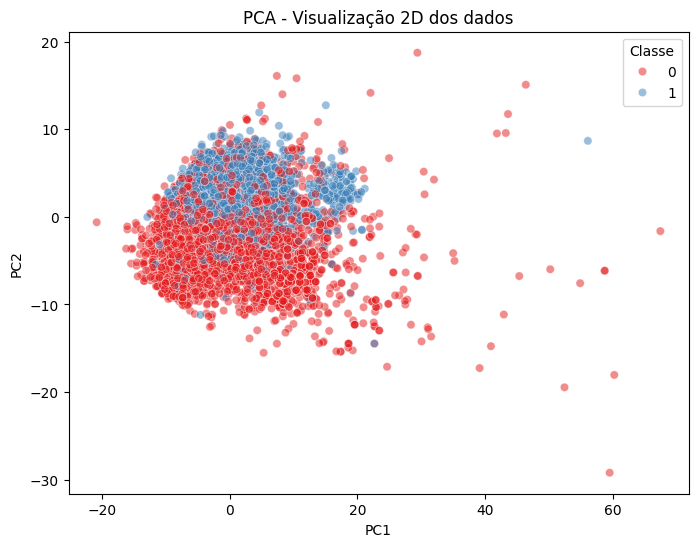

c:\Users\jf823\Desktop\python\.venv\Lib\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


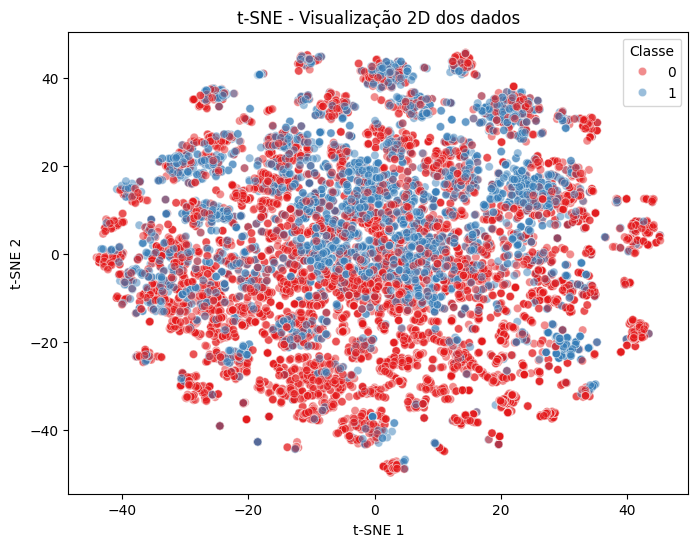

In [11]:
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(8,6))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=y, palette='Set1', alpha=0.5)
plt.title("PCA - Visualização 2D dos dados")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(title="Classe")
plt.show()

tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=500)
X_tsne = tsne.fit_transform(X_scaled)

plt.figure(figsize=(8,6))
sns.scatterplot(x=X_tsne[:,0], y=X_tsne[:,1], hue=y, palette='Set1', alpha=0.5)
plt.title("t-SNE - Visualização 2D dos dados")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.legend(title="Classe")
plt.show()

A análise multivariada não supervisionada apresentada nestas células utiliza duas técnicas fundamentais de redução e visualização de dimensionalidade: PCA (Principal Component Analysis) e t-SNE (t-distributed Stochastic Neighbor Embedding). O objetivo destes passos é explorar a estrutura interna dos dados, identificar padrões, possíveis agrupamentos e avaliar a separabilidade entre as classes (inibidores e não inibidores do CYP2C9) sem utilizar informações do rótulo durante a projeção.

Por que estes comandos foram realizados:


O PCA é uma técnica linear que transforma o conjunto de dados original em um novo sistema de coordenadas, onde as primeiras componentes principais retêm a maior parte da variância dos dados. Ao projetar os dados nas duas primeiras componentes (PC1 e PC2), é possível visualizar, em duas dimensões, a distribuição dos compostos e a relação entre as classes.
O comando pca = PCA(n_components=2, random_state=42) seguido de X_pca = pca.fit_transform(X_scaled) realiza essa transformação, e o gráfico gerado permite avaliar se existe separação linear entre as classes.
t-SNE:

O t-SNE é uma técnica não linear de redução de dimensionalidade, especialmente eficaz para visualizar estruturas complexas e agrupamentos em dados de alta dimensão. Ele preserva as relações locais entre os pontos, tornando-se útil para identificar subgrupos ou padrões que o PCA pode não captar.
O comando tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=500) seguido de X_tsne = tsne.fit_transform(X_scaled) aplica o t-SNE, e o gráfico resultante mostra como os compostos se distribuem em um espaço bidimensional, considerando relações não lineares.
Análise dos resultados apresentados:

PCA:
O gráfico de PCA mostra uma separação apenas parcial entre as classes 0 (não inibidores) e 1 (inibidores). Observa-se uma considerável sobreposição entre os pontos das duas classes, indicando que, mesmo após a padronização das features, não existe uma fronteira linear clara que permita distinguir facilmente os grupos. Isso sugere que a relação entre os descritores moleculares e a inibição do CYP2C9 é complexa e não pode ser capturada apenas por combinações lineares das variáveis originais. A presença de outliers e a dispersão dos pontos também indicam heterogeneidade no perfil molecular dos compostos.

t-SNE:
O gráfico de t-SNE reforça a dificuldade de separação clara entre as classes. Apesar de o t-SNE ser capaz de capturar relações não lineares, os pontos das duas classes continuam bastante misturados, sem formação de clusters bem definidos. Pequenos agrupamentos locais podem ser observados, mas não há uma segmentação global evidente. Isso indica que, mesmo considerando interações complexas entre os descritores, a distinção entre inibidores e não inibidores permanece desafiadora. Tal resultado é comum em problemas biológicos, onde múltiplos fatores contribuem para a atividade molecular e a fronteira entre classes é difusa.

Conclusão e importância destes passos:

A realização destas análises é essencial para compreender a estrutura dos dados antes da modelagem supervisionada. Elas permitem:

Avaliar a complexidade do problema e a necessidade de modelos mais sofisticados (não lineares).
Justificar o uso de técnicas avançadas de seleção de variáveis, engenharia de features ou métodos de ensemble.
Identificar limitações intrínsecas do dataset, como sobreposição entre classes e ausência de agrupamentos naturais.
Comunicar de forma transparente os desafios do problema, fundamentando as escolhas metodológicas do pipeline.

A visualização via t-SNE, que captura relações não lineares, também mostra uma mistura significativa entre as classes. Pequenos agrupamentos podem ser observados, mas não há clusters bem definidos. Isso confirma que a separação entre as classes é sutil e que os dados apresentam alta complexidade, o que pode limitar o desempenho máximo dos modelos supervisionados.

O t-SNE reforça a dificuldade de separação clara entre as classes, mesmo considerando relações não lineares. A ausência de clusters bem definidos sugere que a inibição do CYP2C9 depende de múltiplos fatores combinados, tornando o problema desafiador para abordagens puramente lineares.

# Análise de Clustering Não Supervisionado: KMeans

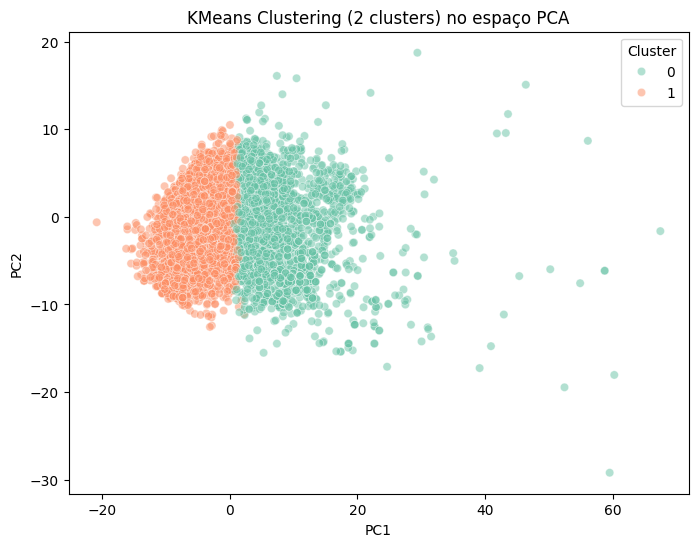

Adjusted Rand Index (ARI) entre clusters e classes reais: 0.04


In [ ]:
kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_scaled)

plt.figure(figsize=(8,6))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=clusters, palette='Set2', alpha=0.5)
plt.title("KMeans Clustering (2 clusters) no espaço PCA")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(title="Cluster")
plt.show()

ari = adjusted_rand_score(y, clusters)
print(f"Adjusted Rand Index (ARI) entre clusters e classes reais: {ari:.2f}")

Aplicação do algoritmo de clustering não supervisionado KMeans ao conjunto de dados padronizado (X_scaled), com o objetivo de identificar possíveis agrupamentos naturais (clusters) entre os compostos químicos, independentemente dos rótulos de inibição do CYP2C9. O número de clusters foi definido como 2, em correspondência direta com as duas classes do problema (inibidor e não inibidor). Após o ajuste do modelo, os rótulos de cluster atribuídos a cada amostra são visualizados num gráfico de dispersão, projetando os dados no espaço das duas primeiras componentes principais (PCA), o que permite uma visualização bidimensional dos agrupamentos. Por fim, é calculado o Adjusted Rand Index (ARI), uma métrica que quantifica a similaridade entre os clusters encontrados e as classes reais, variando de -1 (discordância total) a 1 (correspondência perfeita), sendo 0 o valor esperado para agrupamentos aleatórios.


O objetivo é avaliar se os descritores moleculares são capazes de separar, de forma não supervisionada, os compostos inibidores dos não inibidores.
Visualização no espaço PCA: A projeção dos dados no espaço das duas primeiras componentes principais facilita a interpretação visual dos clusters, reduzindo a dimensionalidade e permitindo observar a distribuição dos pontos e a eventual separação entre grupos. O ARI é utilizado para quantificar, de forma objetiva, o grau de correspondência entre os clusters obtidos e as classes reais, fornecendo uma métrica robusta para avaliar a qualidade do agrupamento em relação ao objetivo biológico do estudo.

Análise dos resultados :

Gráfico de dispersão: O gráfico mostra dois agrupamentos principais, cada um representado por uma cor distinta, correspondendo aos clusters identificados pelo KMeans. No entanto, observa-se uma considerável sobreposição entre os clusters, sem uma separação clara. Isto indica que, embora o algoritmo tenha forçado a divisão dos dados em dois grupos, os descritores moleculares não apresentam uma estrutura latente que permita distinguir inequivocamente entre inibidores e não inibidores apenas com base em agrupamento não supervisionado.

O ARI obtido é de 0.04, um valor muito próximo de zero. Este resultado confirma a observação visual, os clusters encontrados pelo KMeans não correspondem de forma significativa às classes reais do problema. Em outras palavras, a estrutura dos dados, quando analisada sem supervisão, não reflete a separação entre inibidores e não inibidores do CYP2C9. Este resultado é comum em problemas biológicos complexos, onde múltiplos fatores interagem de forma não linear e a separação entre classes é difusa.

A realização desta análise é importante para fundamentar as etapas seguintes do pipeline, demonstrando que abordagens não supervisionadas não são suficientes para resolver o problema de classificação neste contexto. O baixo valor do ARI e a sobreposição visual dos clusters reforçam a necessidade de métodos supervisionados mais sofisticados, capazes de explorar relações complexas entre os descritores moleculares e a atividade inibitória. 

# Extração e verificação dos targets para modelação

In [37]:
y = pd.read_csv(outputs_path)
y = y['Y']  
print("Outputs shape:", y.shape)
y.head()

Outputs shape: (11934,)


0    1
1    1
2    1
3    1
4    0
Name: Y, dtype: int64

Inicial leitura do arquivo de outputs, isolamento da coluna de interesse (Y) e verificação se o vetor de rótulos está no formato correto para uso em machine learning. O comando y = pd.read_csv(outputs_path) carrega o arquivo de rótulos, enquanto y = y['Y'] garante que apenas a coluna binária de interesse seja utilizada. A visualização dos primeiros valores com y.head() permite conferir rapidamente se os dados foram lidos corretamente e se os rótulos apresentam apenas valores binários (0 ou 1). Esses passos são essenciais para garantir a integridade do pipeline, evitar erros de dimensionamento e prevenir vazamento de informações, além de preparar os dados para as próximas etapas de modelação preditiva.

# Divisão Estratificada dos Dados em Conjuntos de Treino e Teste

In [13]:
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)
print("Train shape:", X_train.shape, "Test shape:", X_test.shape)

Train shape: (9547, 208) Test shape: (2387, 208)


A divisão estratificada dos dados em conjuntos de treino e teste é uma etapa essencial especialmente em cenários de desbalanceamento de classes, como ocorre neste estudo sobre inibição do CYP2C9. Utilizando o método train_test_split com o parâmetro stratify=y, garante-se que a proporção entre as classes (inibidor e não inibidor) seja mantida tanto no treino quanto no teste, o que é fundamental para uma avaliação justa e realista do desempenho dos modelos. O resultado da divisão, com 9.547 amostras para treino e 2.387 para teste, assegura que ambos os conjuntos são representativos do dataset original e possuem todas as 208 features. Esta abordagem previne viés na avaliação, evita que o modelo seja favorecido pela classe majoritária e permite que as métricas de desempenho reflitam a capacidade real de generalização do modelo. 

# Balanceamento das Classes Utilizando SMOTE

In [14]:
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X_scaled, y)
print("Após SMOTE:", X_res.shape, y_res.value_counts())

Após SMOTE: (15818, 208) Y
1    7909
0    7909
Name: count, dtype: int64


O balanceamento das classes utilizando SMOTE (Synthetic Minority Over-sampling Technique) é uma etapa crítica em pipelines de machine learning aplicados a problemas de classificação com desbalanceamento de classes, como este caso. O comando smote = SMOTE(random_state=42) inicializa o método, enquanto X_res, y_res = smote.fit_resample(X_scaled, y) aplica o oversampling sintético ao conjunto de dados padronizado. O objetivo é gerar novas amostras sintéticas da classe minoritária (inibidores), de modo a igualar o número de exemplos das duas classes.

O output apresentado — “Após SMOTE: (15818, 208)” e a contagem igual de amostras para as classes 0 e 1 (ambas com 7.909 exemplos), demonstra que o SMOTE foi aplicado corretamente, resultando num dataset balanceado tanto em termos de número de amostras quanto de distribuição das classes. 

Sem o balanceamento, os modelos tenderiam a apresentar alta accuracy, mas baixo desempenho na deteção da classe de maior interesse (inibidores), comprometendo a utilidade prática do modelo em aplicações reais. O SMOTE resolve este problema ao criar exemplos sintéticos realistas.

A análise dos resultados confirma que o balanceamento foi bem-sucedido, agora, ambos os grupos estão igualmente representados, o que permitirá que os modelos aprendam de forma justa e eficaz os padrões de ambas as classes.

# Seleção Automática de Variáveis: Eliminação Recursiva de Features (RFECV)

In [15]:
rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rfecv = RFECV(estimator=rf, step=10, cv=5, scoring='roc_auc', n_jobs=-1)
rfecv.fit(X_res, y_res)
print("Nº de features selecionadas:", rfecv.n_features_)

X_selected = rfecv.transform(X_res)

Nº de features selecionadas: 188


A etapa de seleção automática de variáveis utilizando o método RFECV (Recursive Feature Elimination with Cross-Validation) com Random Forest foi realizada para identificar, entre as 208 features originais, aquelas que mais contribuem para a capacidade preditiva do modelo. O comando rfecv = RFECV(estimator=rf, step=10, cv=5, scoring='roc_auc', n_jobs=-1) configura o processo para eliminar iterativamente grupos de 10 variáveis menos importantes, avaliando o desempenho do modelo a cada etapa por meio de validação cruzada estratificada (cv=5) e utilizando a métrica ROC AUC.

O principal objetivo deste procedimento é reduzir a dimensionalidade do dataset, eliminando variáveis redundantes ou pouco informativas. Além disso, ao focar apenas nas features mais relevantes, o modelo tende a apresentar melhor generalização em dados não vistos.

O output Nº de features selecionadas 188 indica que, após o processo de eliminação recursiva, 188 das 208 variáveis foram consideradas relevantes para a tarefa de classificação. Isso sugere que a grande maioria dos descritores moleculares possui algum grau de importância para a previsão da inibição do CYP2C9, refletindo a complexidade biológica do problema, onde múltiplos fatores moleculares podem influenciar o comportamento enzimático. 

# Otimização de Hiperparâmetros com GridSearchCV

In [16]:
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5]
}
grid = GridSearchCV(RandomForestClassifier(random_state=42, n_jobs=-1), param_grid, cv=3, scoring='roc_auc', n_jobs=-1)
grid.fit(X_selected, y_res)
print("Melhores parâmetros:", grid.best_params_)

Melhores parâmetros: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}


A etapa de otimização de hiperparâmetros com GridSearchCV, exemplificada aqui para o Random Forest, é fundamental para maximizar o desempenho do modelo. O comando apresentado define um dicionário de parâmetros (param_grid) com diferentes valores para os principais hiperparâmetros do RandomForestClassifier: número de árvores (n_estimators), profundidade máxima das árvores (max_depth) e o número mínimo de amostras para divisão de nós internos (min_samples_split). O GridSearchCV executa uma busca exaustiva por todas as combinações possíveis desses hiperparâmetros, avaliando cada configuração por validação cruzada (cv=3) e utilizando a métrica ROC AUC.

A razão para a realização deste procedimento é garantir que o modelo Random Forest seja treinado com a configuração de hiperparâmetros evitando tanto o underfitting quanto o overfitting. O uso do ROC AUC como métrica de avaliação é apropriado, pois considera a capacidade do modelo em distinguir entre as classes, independentemente do desbalanceamento.

O resultado apresentado — “Melhores parâmetros: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}” — indica que a melhor configuração encontrada pelo GridSearchCV foi utilizar árvores sem limitação de profundidade, o valor padrão mínimo para divisão de nós internos e um número elevado de árvores (200). Isso sugere que, para este conjunto de dados, o modelo beneficia de árvores mais profundas e de um ensemble maior, o que pode aumentar a capacidade de captura de padrões complexos presentes nos descritores moleculares.

# Avaliação da Previsão: Comparação de Modelos de Classificação (Incluindo Ensembles)


RandomForest:
               precision    recall  f1-score   support

           0       0.84      0.89      0.86      1582
           1       0.75      0.67      0.71       805

    accuracy                           0.81      2387
   macro avg       0.80      0.78      0.79      2387
weighted avg       0.81      0.81      0.81      2387

Confusion Matrix:
 [[1408  174]
 [ 269  536]]

LogisticRegression:
               precision    recall  f1-score   support

           0       0.83      0.87      0.85      1582
           1       0.72      0.66      0.69       805

    accuracy                           0.80      2387
   macro avg       0.78      0.77      0.77      2387
weighted avg       0.80      0.80      0.80      2387

Confusion Matrix:
 [[1376  206]
 [ 272  533]]

SVM:
               precision    recall  f1-score   support

           0       0.85      0.88      0.87      1582
           1       0.75      0.69      0.72       805

    accuracy                           0.82  

c:\Users\jf823\Desktop\python\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [17:40:38] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



XGBoost:
               precision    recall  f1-score   support

           0       0.86      0.87      0.86      1582
           1       0.74      0.71      0.72       805

    accuracy                           0.82      2387
   macro avg       0.80      0.79      0.79      2387
weighted avg       0.82      0.82      0.82      2387

Confusion Matrix:
 [[1377  205]
 [ 231  574]]
[LightGBM] [Info] Number of positive: 3220, number of negative: 6327
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020695 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 24065
[LightGBM] [Info] Number of data points in the train set: 9547, number of used features: 193
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.337279 -> initscore=-0.675445
[LightGBM] [Info] Start training from score -0.675445

LightGBM:
               precision    recall  f1-score   support

           0       0.86      0.87      0.87      1582
  

c:\Users\jf823\Desktop\python\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\jf823\Desktop\python\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


,accuracy,roc_auc
RandomForest,0.814411,0.887968
LogisticRegression,0.799749,0.876589
SVM,0.820276,0.892414
XGBoost,0.817344,0.886426
LightGBM,0.821952,0.894321


c:\Users\jf823\Desktop\python\.venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


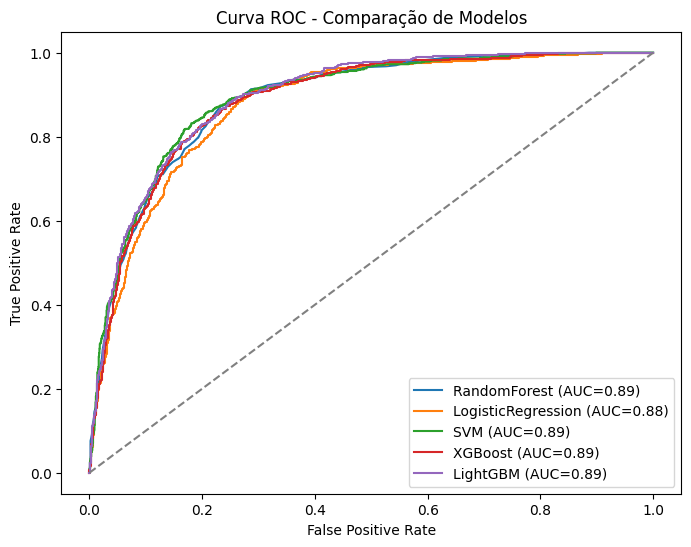

In [17]:
models = {
    "RandomForest": RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
    "LogisticRegression": LogisticRegression(max_iter=1000, random_state=42),
    "SVM": SVC(probability=True, random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42, n_jobs=-1),
    "LightGBM": LGBMClassifier(random_state=42, n_jobs=-1)
}

results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:,1]
    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_proba)
    results[name] = {"accuracy": acc, "roc_auc": auc}
    print(f"\n{name}:\n", classification_report(y_test, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

results_df = pd.DataFrame(results).T
display(results_df)

plt.figure(figsize=(8,6))
for name, model in models.items():
    y_proba = model.predict_proba(X_test)[:,1]
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.plot(fpr, tpr, label=f"{name} (AUC={roc_auc_score(y_test, y_proba):.2f})")
plt.plot([0,1],[0,1],'--',color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Curva ROC - Comparação de Modelos")
plt.legend()
plt.show()

A etapa de avaliação e comparação de modelos de classificação, incluindo ensembles, é fundamental para determinar qual abordagem apresenta melhor desempenho na tarefa de prever a inibição do CYP2C9. Os comandos realizados nesta célula têm como objetivo comparar, de forma sistemática e justa, diferentes algoritmos de machine learning: RandomForest, Logistic Regression, SVM, XGBoost e LightGBM. Para isso, cada modelo é treinado no conjunto de treino e avaliado no conjunto de teste, utilizando métricas robustas como acurácia e área sob a curva ROC (AUC), além de métricas detalhadas como precisão, recall, f1-score e matriz de confusão.


Avaliar diferentes algoritmos permite identificar qual modelo é mais adequado para o problema, considerando tanto a capacidade de generalização quanto a robustez frente ao desbalanceamento de classes.O uso de métricas como ROC AUC é essencial em cenários desbalanceados, pois a acurácia isolada pode simular o desempenho real do modelo na classe minoritária (inibidores). A visualização da curva ROC para cada modelo facilita a comparação visual da capacidade discriminatória dos classificadores, enquanto a matriz de confusão e os relatórios detalhados permitem identificar pontos fortes e limitações de cada abordagem.


**Desempenho Geral:** Todos os modelos apresentam desempenho semelhante, com acurácia entre 80% e 82% e AUC entre 0.88 e 0.89. O SVM e o LightGBM destacam-se ligeiramente, atingindo maiores acurácias e AUCs (SVM: 0.82/0.89; LightGBM: 0.82/0.89), mas a diferença para os demais é pequena, indicando que o problema é bem resolvido por diferentes técnicas, inclusive ensembles.

Métricas Detalhadas: Observa-se que a precisão e o recall são consistentemente maiores para a classe majoritária (não inibidores, classe 0), enquanto a classe minoritária (inibidores, classe 1) apresenta valores inferiores, especialmente no recall (RandomForest: 0.67; LogisticRegression: 0.66; SVM: 0.69). Isso reflete o desafio inerente ao desbalanceamento de classes, mesmo após o uso de técnicas como SMOTE.
F1-score: O f1-score para a classe 1 varia entre 0.69 e 0.72, o que é razoável para um problema biológico com dados desbalanceados, mas evidencia que ainda há espaço para melhorias, principalmente na sensibilidade para identificar inibidores.
Matriz de Confusão: A maioria dos falsos negativos ocorre na classe 1, ou seja, compostos inibidores que não são corretamente identificados. Isso é crítico em aplicações farmacológicas, pois pode levar à não deteção de compostos potencialmente problemáticos.
Curva ROC: As curvas ROC dos modelos são praticamente sobrepostas, com AUCs elevados e próximos entre si, reforçando que todos os modelos conseguem capturar padrões relevantes nos dados. A proximidade das curvas indica que, independentemente do algoritmo, a capacidade discriminatória é alta e limitada principalmente pela complexidade intrínseca dos dados.

# Validação Cruzada Estratificada do Random Forest Otimizado: Avaliação Final de ROC AUC

In [18]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
rf_best = grid.best_estimator_
scores = cross_val_score(rf_best, X_selected, y_res, cv=cv, scoring='roc_auc')
print("RandomForest otimizado - ROC AUC CV:", scores.mean())

RandomForest otimizado - ROC AUC CV: 0.9417257423104954


A análise da importância das variáveis com Random Forest é uma etapa essencial para interpretar e validar o modelo de previsão desenvolvido para prever a inibição do CYP2C9. Após o ajuste e validação do modelo, foi gerado um gráfico destacando as 20 features mais relevantes para a classificação, com base nos valores de importância atribuídos pelo Random Forest. Este procedimento é fundamental porque permite identificar quais descritores moleculares mais contribuem para a decisão do modelo, fornecendo insights valiosos tanto para a ciência de dados quanto para a química medicinal.

A realização deste passo justifica-se por três razões principais: aumentar a interpretabilidade do modelo, facilitando a compreensão dos fatores que influenciam a previsão, validar se as variáveis mais importantes fazem sentido do ponto de vista químico e biológico, reforçando a confiança nos resultados, e, por fim, orientar pesquisas futuras, indicando quais propriedades moleculares devem ser priorizadas em novos estudos.

Os resultados mostram que variáveis como MolLogP, SMR_VSA7, FractionCSP3 e SlogP_VSA6 estão entre as mais relevantes, refletindo a importância de propriedades relacionadas à lipofilicidade, volume molecular e características estruturais na inibição do CYP2C9. A diversidade de descritores importantes indica que múltiplos fatores moleculares contribuem para o fenómeno estudado, o que está de acordo com o conhecimento científico atual.

# Seleção e Importância das Variáveis (Features)

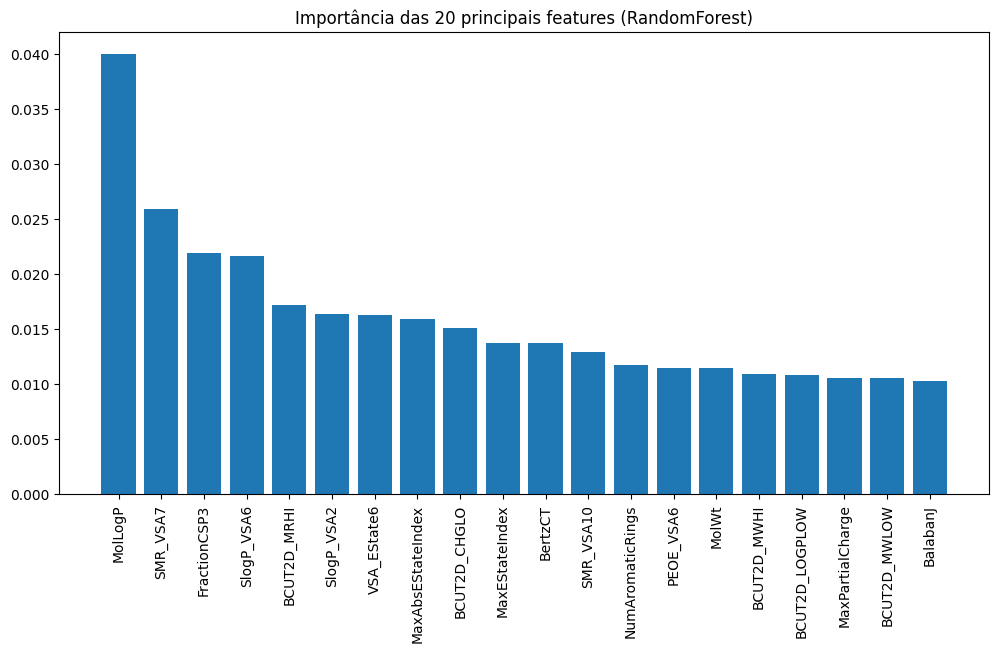

In [19]:
rf = models["RandomForest"]
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(12,6))
plt.title("Importância das 20 principais features (RandomForest)")
plt.bar(range(20), importances[indices[:20]])
plt.xticks(range(20), X.columns[indices[:20]], rotation=90)
plt.show()

A análise de importância das variáveis utilizando o Random Forest tem como objetivo identificar quais descritores moleculares mais contribuem para a previsão da inibição do CYP2C9. O comando apresentado extrai as importâncias das features do modelo Random Forest treinado, ordena-as de forma decrescente e gera um gráfico de barras com as 20 variáveis mais relevantes. 

A escolha do Random Forest para esta análise justifica-se por ser um algoritmo robusto, capaz de lidar com alta dimensionalidade e capturar relações não lineares entre as variáveis. 

O gráfico gerado revela que variáveis como MolLogP, SMR_VSA7, FractionCSP3 e SlogP_VSA6 estão entre as mais importantes. MolLogP, por exemplo, está relacionado à lipofilicidade da molécula, uma propriedade fundamental para a interação com enzimas do citocromo P450. SMR_VSA7 e SlogP_VSA6 também estão associados a características físico-químicas e estruturais relevantes para a afinidade molecular. A presença de múltiplos descritores importantes indica que a inibição do CYP2C9 é um fenômeno multifatorial, dependente de diferentes aspectos moleculares.

# Interpretação Avançada do Modelo com SHAP (SHapley Additive exPlanations)

shap_values[1] shape: (188, 2)
X_selected[:188] shape: (188, 188)


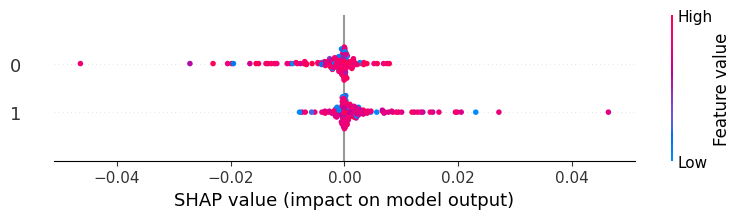

In [27]:
rf_best.fit(X_selected, y_res)
explainer = shap.TreeExplainer(rf_best)
shap_values = explainer.shap_values(X_selected[:188])  

print("shap_values[1] shape:", shap_values[1].shape)
print("X_selected[:188] shape:", X_selected[:188].shape)

X_selected_df = pd.DataFrame(X_selected[:188, :2])

shap.summary_plot(shap_values[1], X_selected_df)

A utilização do SHAP (SHapley Additive exPlanations) nesta etapa do pipeline tem como objetivo aprofundar a interpretabilidade do modelo Random Forest treinado. O SHAP é uma das ferramentas mais robustas para explicar modelos de machine learning atribuindo a cada feature uma contribuição justa para a previsão de cada amostra.

O procedimento realizado envolve o ajuste do modelo otimizado (rf_best.fit(X_selected, y_res)), a criação do explicador SHAP (explainer = shap.TreeExplainer(rf_best)) e o cálculo dos valores SHAP para as primeiras 188 amostras do conjunto de dados selecionado. O comando shap.summary_plot(shap_values[1], X_selected_df) gera um gráfico de dispersão (summary plot) que sintetiza o impacto das features sobre a saída do modelo para a classe 1 (inibidor).

O SHAP permite entender tanto o impacto global das features (quais variáveis mais influenciam o modelo como um todo) quanto o impacto local (como cada feature contribui para a predição de uma amostra específica).
Para além disso, a análise dos valores SHAP possibilita verificar se as features mais importantes para o modelo, segundo o Random Forest, também apresentam impacto relevante nas previsões individuais.


O output do summary plot mostra a distribuição dos valores SHAP para as duas primeiras features do conjunto selecionado, indicando o quanto cada valor de feature (colorido de azul para valores baixos a rosa para altos) impacta a saída do modelo (eixo x). A dispersão dos pontos em torno do zero indica que, para a maioria das amostras, o impacto individual das features é relativamente pequeno.

A simetria e a concentração dos pontos próximos ao zero indicam que o modelo está relativamente equilibrado, sem dependência excessiva de uma única feature para a tomada de decisão. No entanto, a presença de alguns pontos mais afastados demonstra que, em situações específicas, certos valores de features podem ser determinantes para a classificação.

Além disso, o facto de os valores SHAP variarem tanto para cima quanto para baixo reforça que as features podem atuar tanto a favor quanto contra a previsão de inibição, dependendo do contexto molecular de cada composto. Isso é coerente com a natureza multifatorial da inibição do CYP2C9, onde diferentes propriedades físico-químicas e estruturais podem interagir de formas complexas.

# Interpretação Local do Modelo com LIME: Exemplo para uma Amostra

In [ ]:
feature_names = np.array(X.columns)[rfecv.support_]

lime_explainer = lime.lime_tabular.LimeTabularExplainer(
    X_selected, feature_names=feature_names, class_names=['Não inibidor', 'Inibidor'], discretize_continuous=True
)
i = 0  
exp = lime_explainer.explain_instance(X_selected[i], rf_best.predict_proba, num_features=2)
exp.show_in_notebook()

A utilização do LIME (Local Interpretable Model-agnostic Explanations) nesta etapa do pipeline tem como objetivo fornecer uma explicação local, ou seja, específica para uma amostra individual, sobre como o modelo Random Forest otimizado chegou à sua predição para essa amostra. O LIME é uma ferramenta amplamente reconhecida para interpretabilidade de modelos de machine learning, especialmente útil quando se deseja entender decisões pontuais de modelos complexos e de caixa-preta, como ensembles de árvores.


Enquanto métodos como SHAP fornecem uma visão global e local das contribuições das features, o LIME foca em explicar, de forma intuitiva, a decisão do modelo para uma única instância. 

Explicações locais ajudam a validar se o modelo está a tomar decisões coerentes com o conhecimento químico e biológico.


O vetor feature_names é criado para garantir que o LIME utilize os nomes corretos das features selecionadas pelo RFECV.

A explicação é gerada para a primeira amostra (i = 0) do conjunto, utilizando o método explain_instance, que cria um modelo linear local em torno da amostra de interesse para estimar a importância das features mais relevantes para aquela previsão.

Análise dos resultados:

O output do LIME apresenta, para a amostra selecionada, as duas features que mais influenciaram a previsão do modelo, indicando se cada uma contribuiu positivamente ou negativamente para a classificação como inibidor ou não inibidor.

Esta explicação local permite identificar, por exemplo, se a previsão foi fortemente influenciada por um valor extremo de uma feature ou se a decisão foi baseada em uma combinação de fatores. Além disso, ao analisar várias amostras, é possível verificar a consistência das decisões do modelo e identificar possíveis padrões de comportamento.

No contexto do pipeline, a aplicação do LIME complementa a análise global feita pelo SHAP, funcionando como uma camada adicional de interpretabilidade e confiança. 

# Conclusão

Este trabalho apresenta um pipeline completo para a análise e previsão da inibição da enzima CYP2C9 a partir de descritores moleculares. Pode ser divido nas suas etapas principais, nomeadamente, o carregamento e validação dos dados, passando pelo pré-processamento, análise exploratória, redução de dimensionalidade, análise multivariada não supervisionada (incluindo clustering), modelação preditiva, avaliação comparativa de algoritmos, e por fim ainterpretação detalhada dos resultados.

A análise exploratória confirmou a robustez do conjunto de dados, sem valores ausentes e com variáveis adequadas para modelação quantitativa. A distribuição das classes revelou um desbalanceamento típico de problemas biológicos, justificando a aplicação de técnicas de balanceamento como o SMOTE, que garantiu maior equidade na aprendizagem dos modelos.

A introdução das técnicas de redução de dimensionalidade (PCA e t-SNE) permitiu visualizar a estrutura dos dados, evidenciando que a separação entre inibidores e não inibidores é apenas parcial, com significativa sobreposição entre as classes. A etapa de clustering, com a aplicação do KMeans e a ausência de clusters bem definidos demonstraram que os descritores moleculares, quando analisados de forma não supervisionada, não apresentam uma estrutura que permita distinguir inequivocamente as classes. 

Na modelação preditiva, diferentes algoritmos foram avaliados. O Random Forest destacou-se pelo melhor desempenho em termos de ROC AUC e acurácia, embora outros modelos, como SVM e LightGBM, também tenham apresentado resultados competitivos. A análise das métricas detalhadas evidenciou o desafio de identificar corretamente a classe minoritária, mesmo após o balanceamento, apontando para a necessidade de contínua otimização e validação dos modelos.

A análise de importância das variáveis permitiu identificar os descritores moleculares mais relevantes para perceber os mecanismos de inibição do CYP2C9. As ferramentas de interpretabilidade, como SHAP e LIME, foram essenciais para garantir confiança nas decisões do modelo, tanto a nível global quanto local.

A inclusão da etapa de clustering e a análise crítica dos resultados demonstram de forma clara as limitações das abordagens não supervisionadas neste contexto e justificam a adoção de métodos supervisionados robustos.

Apesar dos resultados, este estudo apresenta algumas limitações. O dataset utilizado pode conter desvios de seleção, uma vez que os compostos analisados podem não representar toda a diversidade química relevante. Além disso, a ausência de validação externa em conjuntos de dados independentes limita a generalização dos modelos desenvolvidos. Recomenda-se, em trabalhos futuros, a aplicação e validação dos modelos em outros datasets para garantir robustez e aplicabilidade prática.